In [71]:
import sys
sys.path.append('/home/mz1482/project/vt-bayesian-opt-bopt_debug/')
import pandas as pd
import numpy as np
from data_analysis import *
from graph import *
from BayesOptLib.bayes_opt.bayesian_optimization import BayesianOptimization
from RandomSampler import RandomSampler
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances
matplotlib.use('Qt5Agg')  # or can use 'TkAgg', whatever you have/prefer
from prettytable import PrettyTable
%matplotlib inline

In [72]:
data_path = "/home/mz1482/project/vt-bayesian-opt-bopt_debug/data/simu_data_4000/"
# Reading in the ECGs and labels
# aucs = pd.read_csv(data_path+"Heart1/Heart1_AUCS.csv", header=None).to_numpy()
ecgs = pd.read_csv(data_path+"Heart1/Heart1_SimuData_4000.csv", header=None).to_numpy()
labels = pd.read_csv(data_path+"Heart1/Coord1_4000.csv", header=None).to_numpy() / 1000
uvc = pd.read_csv(data_path+"UVC/Coord1_UVC_4000.csv", header=None).to_numpy()
#getting only left ventricle###
idx=lv_rv(uvc,-1)
uvc=uvc[idx]
uvc= uvc[:,0:3]
ecgs = ecgs[idx]
labels = labels[idx]
############
bounds = get_heart_bounds(labels) # getting bounds 


In [73]:
#read uvc, xyz 
data_xyz=np.loadtxt("/home/mz1482/project/vt-bayesian-opt-bopt_debug/plots/xyz_result_50_al_lv.txt", delimiter=",")
data_uvc=np.loadtxt("/home/mz1482/project/vt-bayesian-opt-bopt_debug/plots/uvc_result_50_al.txt", delimiter=",")
# data_cc=np.loadtxt("/home/mz1482/project/vt-bayesian-opt-bopt_debug/plots/cc_model_50_al.txt", delimiter=",")

In [74]:
data_xyz.shape

(100, 8)

In [75]:
#read ryan's model
data_cc = pd.read_csv("/home/mz1482/project/vt-bayesian-opt-bopt_debug/plots/cc_model_50_al.txt", sep=",", header=None)
data_cc = data_cc.drop(data_cc.columns[[6]], axis=1)
data_cc=data_cc.to_numpy()

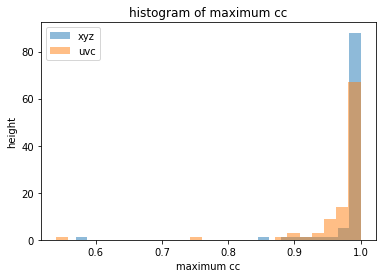

In [14]:
#max_cc analysis
max_cc_xyz = data_xyz[:,4]
max_cc_uvc = data_uvc[:,4]

plt.hist(max_cc_xyz, bins=25, alpha = 0.5, label='xyz')
plt.hist(max_cc_uvc, bins=25, alpha = 0.5, label='uvc')

plt.legend(loc='upper left')
plt.title('histogram of maximum cc')
plt.xlabel('maximum cc')
plt.ylabel('height')
plt.show()


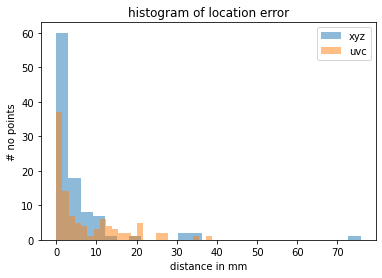

In [17]:
#location error analysis
loc_xyz = data_xyz[:,7]
loc_uvc = data_uvc[:,7]

plt.hist(loc_xyz, bins=25, alpha = 0.5, label='xyz')
plt.hist(loc_uvc, bins=25, alpha = 0.5, label='uvc')

plt.legend(loc='upper right')
plt.title('histogram of location error')
plt.xlabel('distance in mm')
plt.ylabel('# no points')
plt.show()

In [19]:
bad_uvc = data_uvc[np.where(data_uvc[:,6]<12)]
good_uvc = data_uvc[np.where(data_uvc[:,6]==12)]
bad_xyz = data_xyz[np.where(data_xyz[:,6]<12)]
good_xyz = data_xyz[np.where(data_xyz[:,6]==12)]
bad_cc = data_cc[np.where(data_cc[:,5]<12)]
good_cc = data_cc[np.where(data_cc[:,5]==12)]

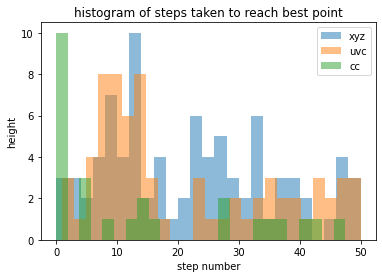

In [29]:
#step analysis
steps_xyz = good_xyz[:,5]
# np.mean(steps_xyz)
steps_uvc = good_uvc[:,5]
# np.mean(steps_uvc)
steps_cc = good_cc[:,4]/2
# np.mean(steps_cc)
plt.hist(steps_xyz, bins=25, alpha = 0.5, label='xyz')
plt.hist(steps_uvc, bins=25, alpha = 0.5, label='uvc')
plt.hist(steps_cc, bins=25, alpha = 0.5, label='cc')
plt.legend(loc='upper right')
plt.title('histogram of steps taken to reach best point')
plt.xlabel('step number')
plt.ylabel('height')
plt.show()

In [ ]:
#bad cases analysis
passing_lead_xyz = bad_xyz[:,6]
passing_lead_uvc = bad_uvc[:,6]
passing_lead_cc = bad_cc[:,5]
plt.hist(passing_lead_xyz, bins=5, alpha = 0.5, label='xyz')
plt.hist(passing_lead_uvc, bins=5, alpha = 0.5, label='uvc')
plt.hist(passing_lead_cc, bins=10, alpha = 0.5, label='cc')
plt.legend(loc='upper right')
plt.title('histogram of passing lead for cases who could not reach 12 lead')
plt.xlabel('# of lead')
plt.ylabel('height')
plt.show()

In [69]:

# bad_cc_target = bad_cc[:,1:4]
# good_cc_target = good_cc[:,1:4]
def heart2(labels,bad_xyz,good_xyz):
    fig = plt.figure(figsize=(8,7))
    ax = fig.gca(projection='3d')
    ax.scatter(xs=labels[:, 0], ys=labels[:, 1], zs=labels[:, 2],s = 5, color = 'gray')
    ax.scatter(xs=bad_xyz[:, 0], ys=bad_xyz[:, 1], zs=bad_xyz[:, 2],s = 50, color = 'red')
    ax.scatter(xs=good_xyz[:, 0], ys=good_xyz[:, 1], zs=good_xyz[:, 2],s = 50, color = 'blue')
#     ax.scatter(target[0], target[1], target[2], color='black', marker = "X", s = 200)
    ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
    fig.suptitle('all target cases for UVC transformed in xyz', fontsize=16)
    plt.show()
#     anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))
#     anim.save('all_uvc_xyz.gif', dpi=80, writer='imagemagick', fps=10)

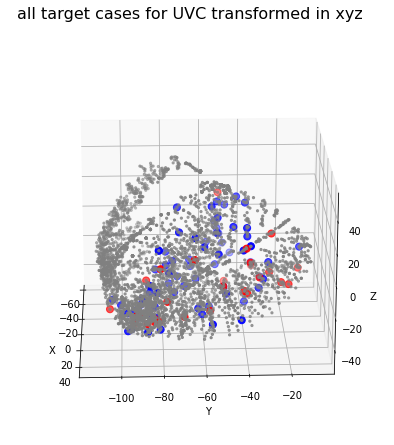

In [70]:
heart2(full_labels,badxyz_points,goodxyz_points)

In [46]:
bad_uvc_target = bad_uvc[:,1:4]
good_uvc_target = good_uvc[:,1:4]

In [47]:
def uvc_xyz_target(uvc_points,uvc_lv,labels_lv):
    '''
    convert the visited uvc to visited xyz
    '''
    visited = uvc_points
    path_xyz=np.empty((0, 3))
    for i in range(len(visited)):
        t=get_index(visited[i],uvc_lv)
        b=labels_lv[t]
        path_xyz = np.append(path_xyz,b.reshape(1,-1),axis=0)
    return path_xyz

In [48]:
badxyz_points = uvc_xyz_target(bad_uvc_target,uvc,labels)
goodxyz_points = uvc_xyz_target(good_uvc_target,uvc,labels)

In [50]:
goodxyz_points.shape

(71, 3)

In [76]:
data2_xyz = np.around(data_xyz,5)
table = PrettyTable(data2_xyz.dtype.names)
table.field_names = ['exp#','x', 'y','z','max_cc','al_step','passing_lead','loc_error']
for row in data2_xyz:
    table.add_row(row)
print(table)

+------+----------+----------+----------+--------+---------+--------------+-----------+
| exp# |    x     |    y     |    z     | max_cc | al_step | passing_lead | loc_error |
+------+----------+----------+----------+--------+---------+--------------+-----------+
| 0.0  | 0.63151  | -62.8861 | 11.0298  |  1.0   |   32.0  |     12.0     |    0.0    |
| 1.0  | -15.0352 | -62.6481 | -1.38384 |  0.99  |   16.0  |     12.0     |    6.04   |
| 2.0  | 28.8532  | -69.5178 | -25.7636 |  1.0   |   26.0  |     12.0     |    0.0    |
| 3.0  | 9.40132  | -22.4864 | -17.0432 |  1.0   |   37.0  |     12.0     |    0.0    |
| 4.0  |  22.551  | -101.314 | -36.0239 |  1.0   |   9.0   |     12.0     |    3.81   |
| 5.0  | 6.08809  | -49.9636 | -29.651  |  0.99  |   32.0  |     12.0     |    5.47   |
| 6.0  | -4.91507 | -68.8197 | -1.3077  |  0.99  |   12.0  |     12.0     |    4.0    |
| 7.0  | -8.3681  | -37.7093 | 29.8263  |  1.0   |   5.0   |     12.0     |    0.0    |
| 8.0  | 10.9528  | -99.6591 | -

In [ ]:
good.shape

In [ ]:
data_cc.shape

In [ ]:
exp_np  = data_xyz[:,0]
xyz = data_xyz[:,1:4]
max_cc = data_xyz[:,4]
al_step = data_xyz[:,5]
passing_lead = data_xyz[:,6]
loc_error = data_xyz[:,7]

In [ ]:
cc_xyz = data_xyz[:,4]
cc_uvc = data_uvc[:,4]
plt.hist(cc_xyz, bins=30, alpha = 0.5, label='xyz')
plt.hist(cc_uvc, bins=30, alpha = 0.5, label='uvc')
plt.legend(loc='upper left')
plt.show()

In [ ]:
step_xyz = data_xyz[:,5]
step_uvc = data_uvc[:,5]
plt.hist(step_xyz, bins=30, alpha = 0.5, label='xyz')
plt.hist(step_uvc, bins=30, alpha = 0.5, label='uvc')
plt.legend(loc='upper left')
plt.show()

In [ ]:
lead_xyz = data_xyz[:,6]
lead_uvc = data_uvc[:,6]
plt.hist(lead_xyz, bins=10, alpha = 0.5, label='xyz')
plt.hist(lead_uvc, bins=10, alpha = 0.5, label='uvc')
plt.legend(loc='upper left')
plt.show()

In [ ]:
loc_xyz = data_xyz[:,7]
loc_uvc = data_uvc[:,7]
plt.hist(loc_xyz, bins=20, alpha = 0.5, label='xyz')
plt.hist(loc_uvc, bins=20, alpha = 0.5, label='uvc')
plt.legend(loc='upper right')
plt.show()

In [59]:
full_labels = pd.read_csv(data_path+"Heart1/Coord1_4000.csv", header=None).to_numpy() / 1000

In [60]:
full_labels.shape

(4000, 3)

In [ ]:
good.shape

In [ ]:
data_uvc=np.loadtxt("/home/mz1482/project/vt-bayesian-opt-bopt_debug/plots/uvc_result.txt", delimiter=",")
data2_uvc = np.around(data_uvc,2)
table = PrettyTable(data2_uvc.dtype.names)
table.field_names = ['exp#','x', 'y','z','max_cc','al_step','passing_lead','loc_error']
for row in data2_uvc:
    table.add_row(row)
print(table)